In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 設定目前程式資料夾路徑(務必自行更改)

In [2]:
folder="/content/drive/MyDrive/解密AI黑盒子分享/"

## import 用到的套件

In [3]:
import time
import numpy as np
from IPython import display
import matplotlib.pyplot as plt
import matplotlib.font_manager as plt_font
twfont1 = plt_font.FontProperties(fname=folder+"字型/kaiu.ttf")

## 載入pytorch相關套件

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader 

## 是否有GPU可以使用

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## 建立DataSet類別

In [6]:
class MyDataset(Dataset):		#需要繼承Dataset 
  def __init__(self): 
    data= np.loadtxt(folder+"資料集/sinewave.csv",delimiter=",")
    tmp_x=[]
    for i in range(len(data)-550):
      tmp_x.append(data[i:i+550])
    data=np.array(tmp_x)
    data_x=data[:,:500]
    data_y=data[:,500:]
    self.data=torch.tensor(data_x).float()
    self.label=torch.tensor(data_y).float()
  def __getitem__(self, index): 
    return self.data[index], self.label[index]
  def __len__(self): 
    return len(self.data)

## 實體化訓練DataSet和DataLoader

In [7]:
TrainDS=MyDataset()
TrainDL=torch.utils.data.DataLoader(dataset=TrainDS,batch_size=100,shuffle=False)

## 建立RNN神經網路類別(RNN、GRU、LSTM任選一個即可，學習率和訓練次數自行調整)

In [8]:
class RNN(nn.Module):
  def __init__(self, InputNode, HiddenNode, LayerNum, OutputNode):
    super(RNN,self).__init__()
    self.Cell=nn.RNN(InputNode, HiddenNode, LayerNum, batch_first=True)
    self.fc =nn.Linear(HiddenNode, OutputNode)
  def forward(self, x):
    Cellout,hx=self.Cell(x,None)
    output = self.fc(Cellout[:,-1,:]) 
    return output

In [ ]:
class GRU(nn.Module):
  def __init__(self, InputNode, HiddenNode, LayerNum, OutputNode):
    super(GRU,self).__init__()
    self.Cell=nn.GRU(InputNode,HiddenNode,LayerNum,batch_first=True)
    self.fc =nn.Linear(HiddenNode,OutputNode)
  def forward(self, x):
    Cellout,hx = self.Cell(x,None)
    output = self.fc(Cellout[:,-1,:]) 
    return output

In [ ]:
class LSTM(nn.Module):
  def __init__(self, InputNode, HiddenNode, LayerNum, OutputNode):
    super(LSTM,self).__init__()
    self.Cell=nn.LSTM(InputNode,HiddenNode,LayerNum,batch_first=True)
    self.fc =nn.Linear(HiddenNode,OutputNode)
  def forward(self, x):
    Cellout,hx = self.Cell(x,None)
    output = self.fc(Cellout[:,-1,:]) 
    return output

## 實體化神經網路，指定損失函數和優化器

In [9]:
InputNode=1
HiddenNode=64
LayerNum=1
OutputNode=50
Net=RNN(InputNode, HiddenNode, LayerNum, OutputNode).to(device)
#Net=GRU(InputNode, HiddenNode, LayerNum, OutputNode).to(device)
#Net=LSTM(InputNode, HiddenNode, LayerNum, OutputNode).to(device)
LossFun= torch.nn.MSELoss()
optim = torch.optim.SGD(Net.parameters(), lr=0.01)
Time_Step = 500
StepLoss=[]  

## 開始訓練神經網路

In [10]:
Net.train()
for epoch in range(500):
  for data,label in TrainDL:
    data=data.reshape(-1, Time_Step, InputNode).to(device)
    optim.zero_grad()
    Yh = Net(data)
    loss = LossFun(Yh, label.to(device))
    StepLoss.append(loss.item())
    loss.backward()
    optim.step()
  display.clear_output(wait=True)
  print("回合：",epoch+1,"損失函數",loss.item())

回合： 500 損失函數 0.00010388951341155916


## 觀察訓練過程中的損失函數Loss變化

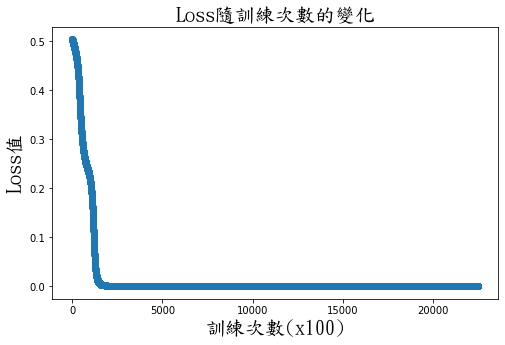

In [ ]:
plt.figure(figsize=(8,5))
plt.title("Loss隨訓練次數的變化",fontproperties=twfont1,fontsize=20) 
plt.xlabel("訓練次數(x100)",fontproperties=twfont1,fontsize=20) 
plt.ylabel("Loss值",fontproperties=twfont1,fontsize=20)
plt.plot(StepLoss,":o")
plt.show()

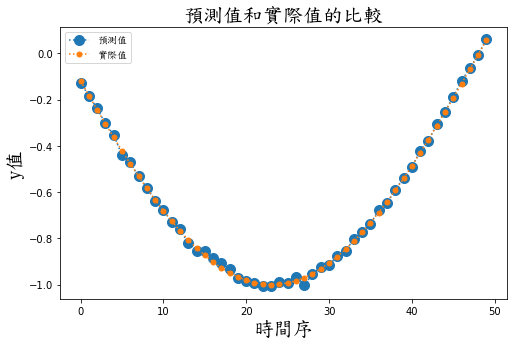

In [ ]:
Net.eval()
for data,label in TrainDL:
  for i in range(len(data)):
    x=data[i].reshape((-1, Time_Step, InputNode))
    y=label[i]
    TestYh=Net(x.to(device))
    plt.figure(figsize=(8,5))
    plt.title("預測值和實際值的比較",fontproperties=twfont1,fontsize=20) 
    plt.xlabel("時間序",fontproperties=twfont1,fontsize=20) 
    plt.ylabel("y值",fontproperties=twfont1,fontsize=20)
    plt.plot(TestYh.cpu().detach().squeeze().numpy(),":o",markersize=10,label="預測值")
    plt.plot(y.numpy(),":o",markersize=5,label="實際值")
    plt.legend(prop=twfont1,fontsize=20)
    plt.pause(0.1)
    display.clear_output(wait=True)